# Get data from github

In [1]:
!git clone https://github.com/PatrickGui/FPDR.git

Cloning into 'FPDR'...
remote: Enumerating objects: 55118, done.
remote: Total 55118 (delta 0), reused 0 (delta 0), pack-reused 55118 (from 1)
Receiving objects: 100% (55118/55118), 987.14 MiB | 50.03 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (55019/55019), done.


In [2]:
!ls /kaggle/working/FPDR/data/split_data/train

ls: cannot access '/kaggle/working/FPDR/data/split_data/train': No such file or directory


# Divide into train/validation/test

In [3]:
import os
import shutil
import random

# Set paths
input_folder = "/kaggle/working/FPDR/data/Field-PlantVillage"
output_folder = "/kaggle/working/FPDR/data/split_data"

train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

# Create train, validation, and test directories
train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")
test_dir = os.path.join(output_folder, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Process each class (subfolder)
for category in os.listdir(input_folder):
    category_path = os.path.join(input_folder, category)
    
    if os.path.isdir(category_path):  # Ensure it's a directory
        images = os.listdir(category_path)
        random.shuffle(images)  # Shuffle images randomly
        
        train_size = int(len(images) * train_ratio)
        val_size = int(len(images) * val_ratio)

        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]  # Remaining images for testing

        # Create category folders in train, validation, and test directories
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Move images to respective folders
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))

        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

print("Dataset split into train, validation, and test sets successfully!")

Dataset split into train, validation, and test sets successfully!


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetV2B0, InceptionV3
from tensorflow.keras.layers import Input, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# Data paths
data_dir = "/kaggle/working/FPDR/data/split_data"
img_size = (256, 256)
batch_size = 32
num_epochs = 20

In [5]:
datagen = ImageDataGenerator(
    rescale=1./ 255,
    rotation_range=20,        # Rotate images by up to 20 degrees
    width_shift_range=0.2,    # Shift width by up to 20%
    height_shift_range=0.2,   # Shift height by up to 20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in/out by 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode="nearest"       # Fill in missing pixels after transformation
)

train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_test_datagen.flow_from_directory(
    data_dir + "/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    data_dir + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)

Found 517 images belonging to 38 classes.
Found 51 images belonging to 38 classes.
Found 97 images belonging to 38 classes.


# Transfer

In [6]:
def build_model(base_model, num_classes):
    base_model.trainable = False  # Giữ nguyên trọng số của mô hình gốc

    inputs = Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)  
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

# Define models
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "InceptionV0": InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "EfficientNetV2": EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-6-35e351613647>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training ResNet50...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 961ms/step - accuracy: 0.0165 - loss: 4.0881 - val_accuracy: 0.0784 - val_loss: 3.5615
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.0577 - loss: 3.7068 - val_accuracy: 0.0784 - val_loss: 3.5121
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.0473 - loss: 3.6706 - val_accuracy: 0.0784 - val_loss: 3.5039
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.0503 - loss: 3.6313 - val_accuracy: 0.0784 - val_loss: 3.5042
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.0557 - loss: 3.6087 - val_accuracy: 0.0784 - val_loss: 3.5047
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.0382 - loss: 3.6498 - val_accuracy: 0.1176 - val_loss: 3.5015
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.0482 - loss: 3.5828 - val_accuracy: 0.0784 - val_loss: 3.4892
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.0559 - loss: 3.6331 - val_accuracy: 0.0784 - val

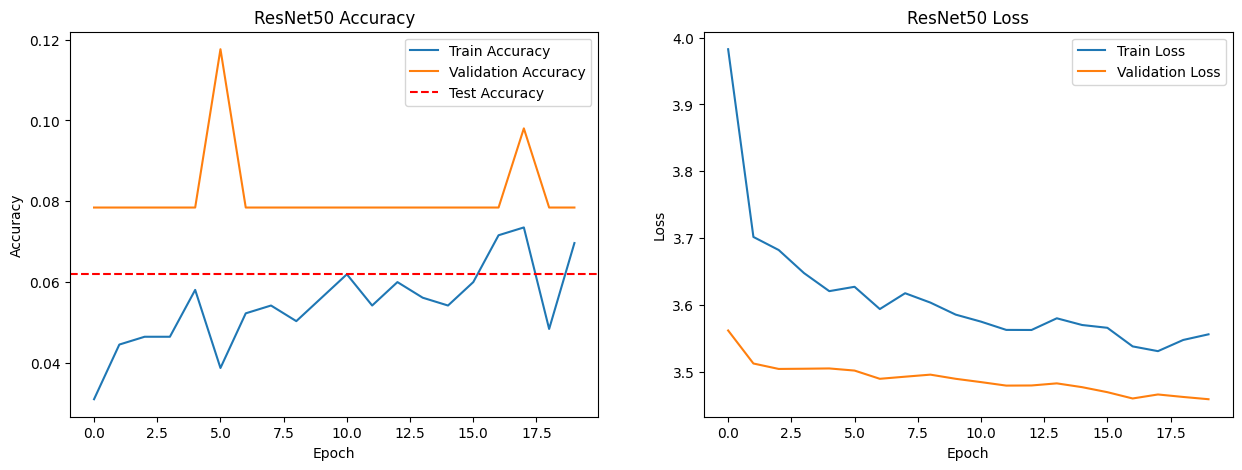

Generating confusion matrix for ResNet50...

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


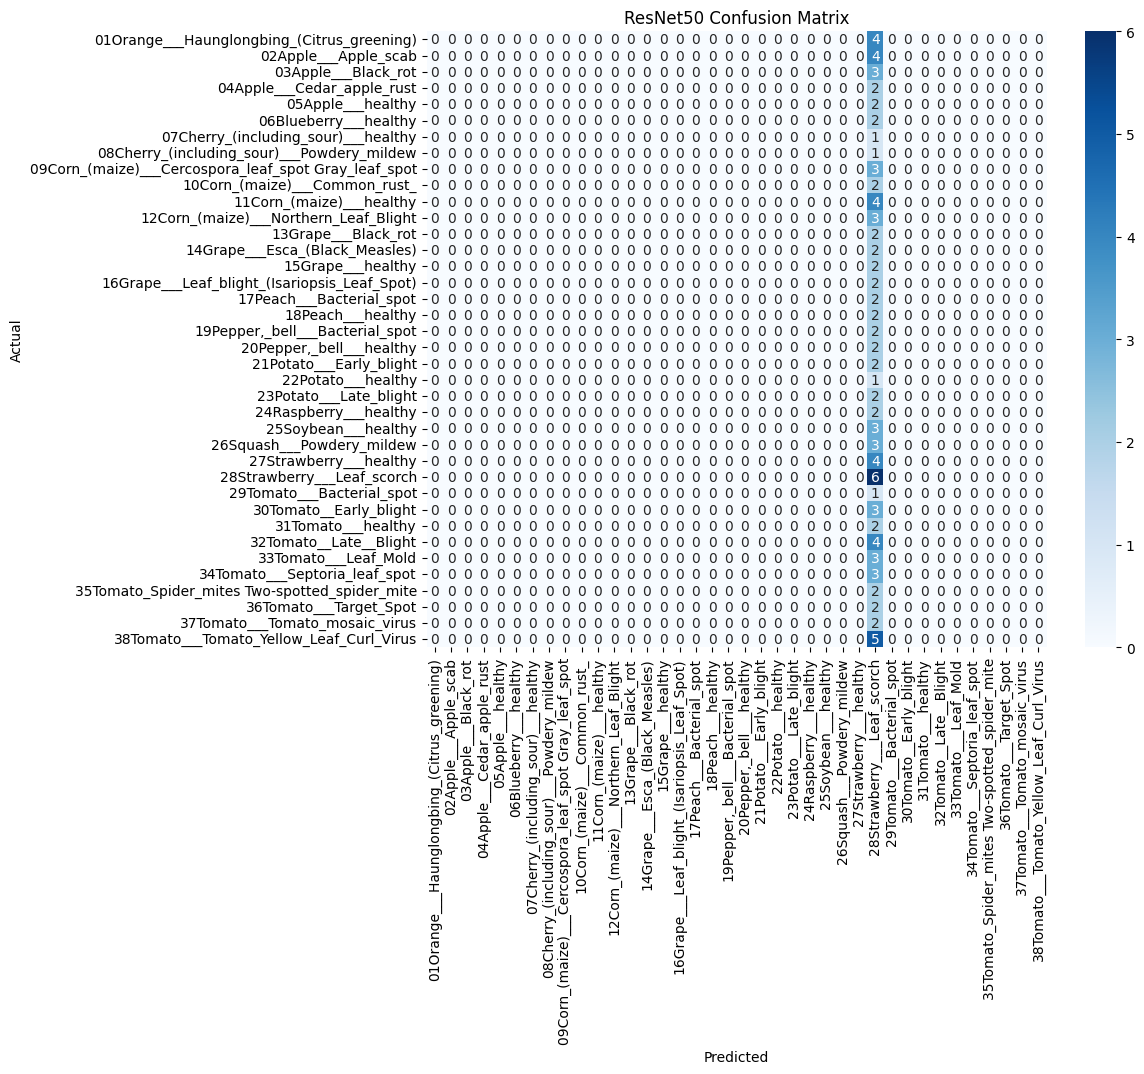

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

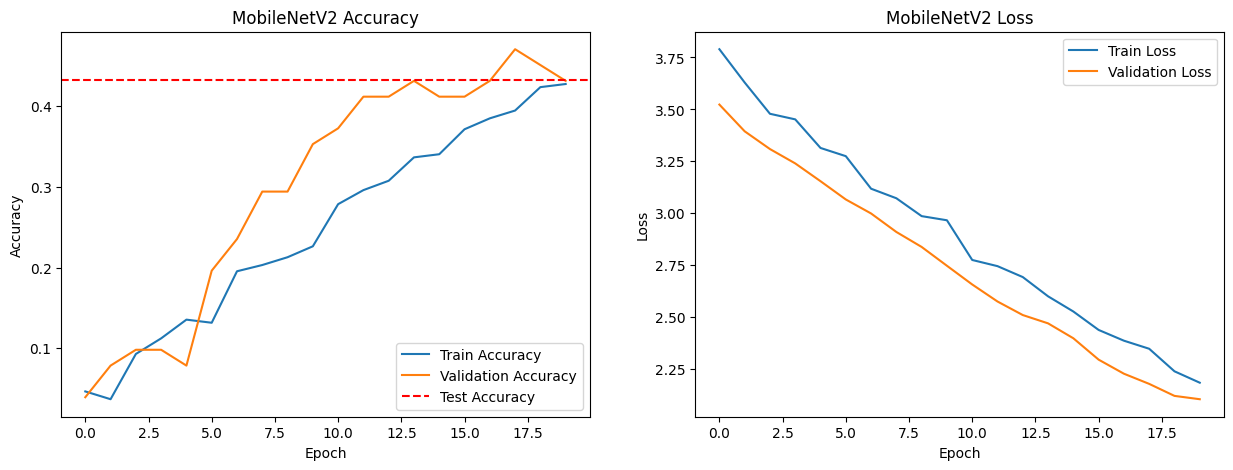

Generating confusion matrix for MobileNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step


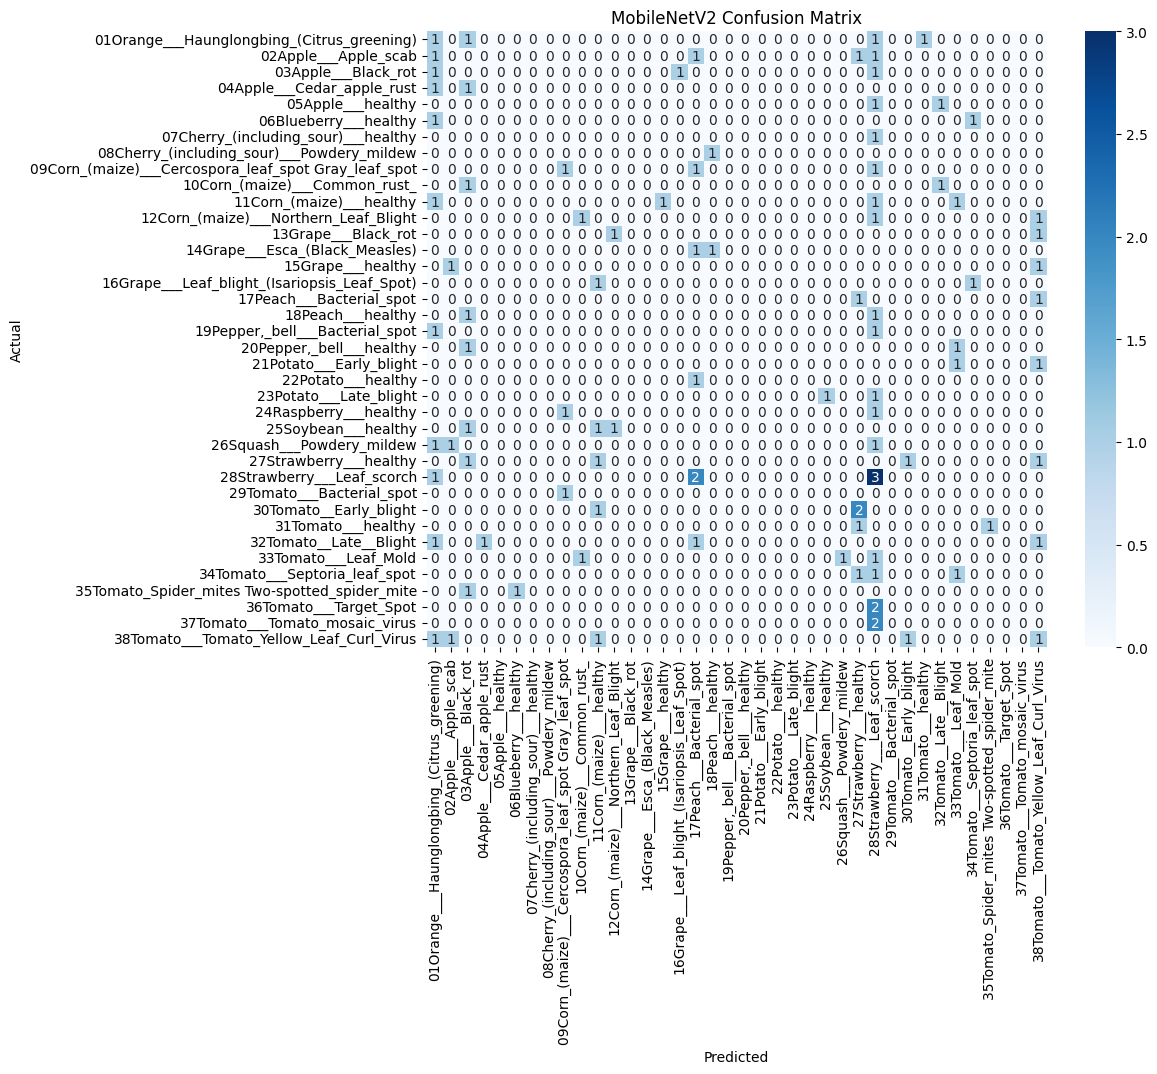

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.09      0.25      0.13         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.33      0.33      0.33         3
                       10Corn_(maize)___Common_rust_       

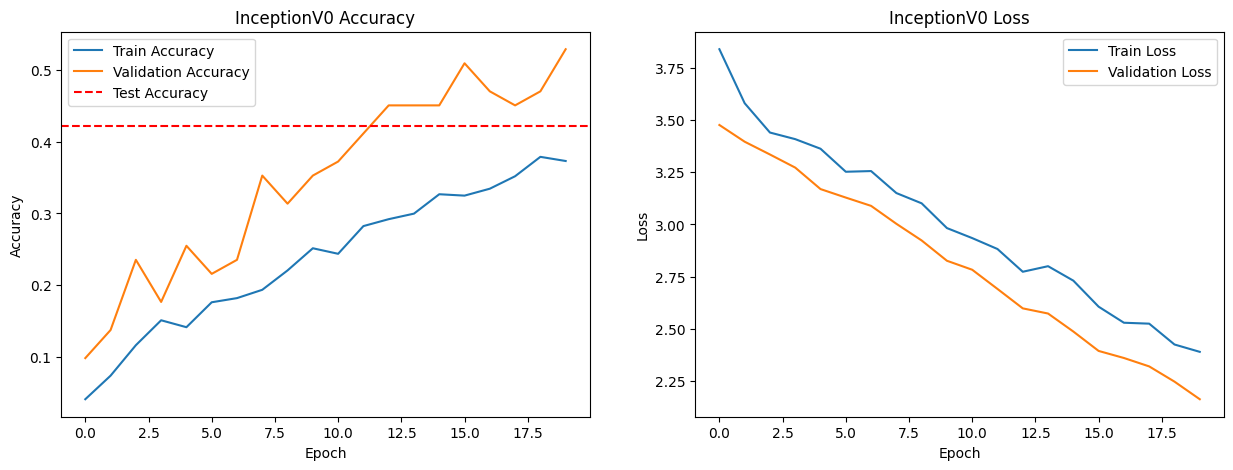

Generating confusion matrix for InceptionV0...

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


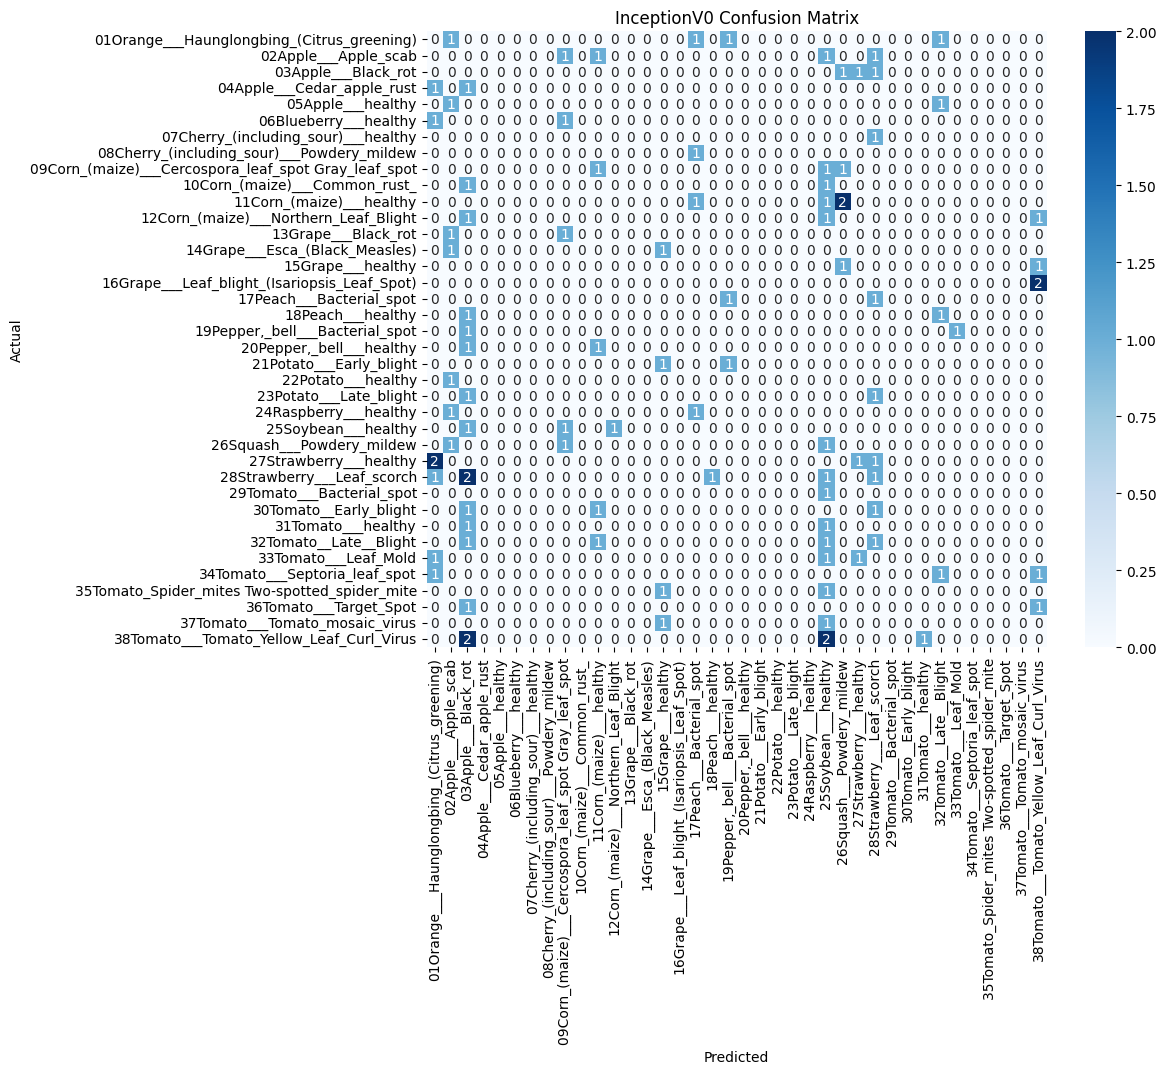

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

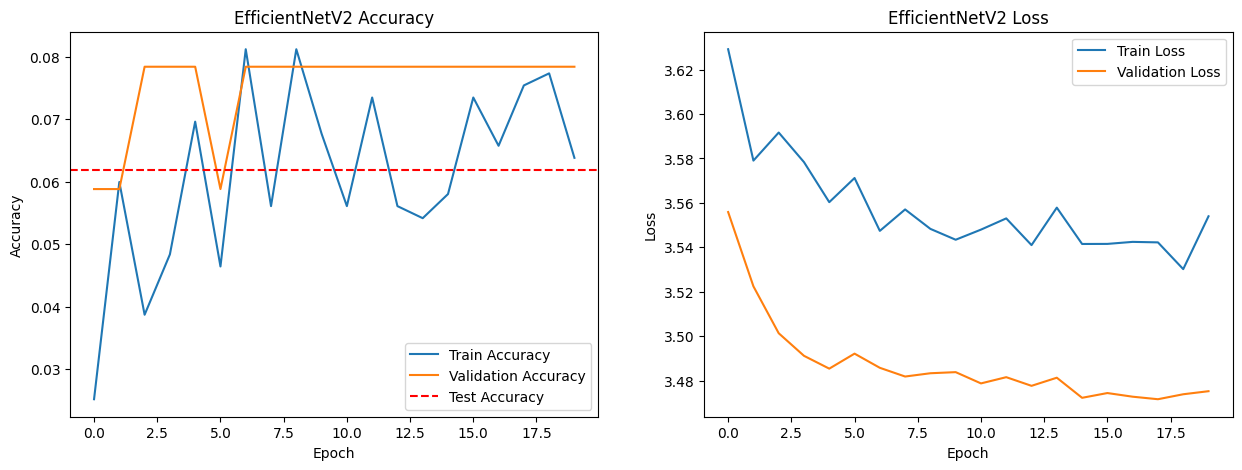

Generating confusion matrix for EfficientNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


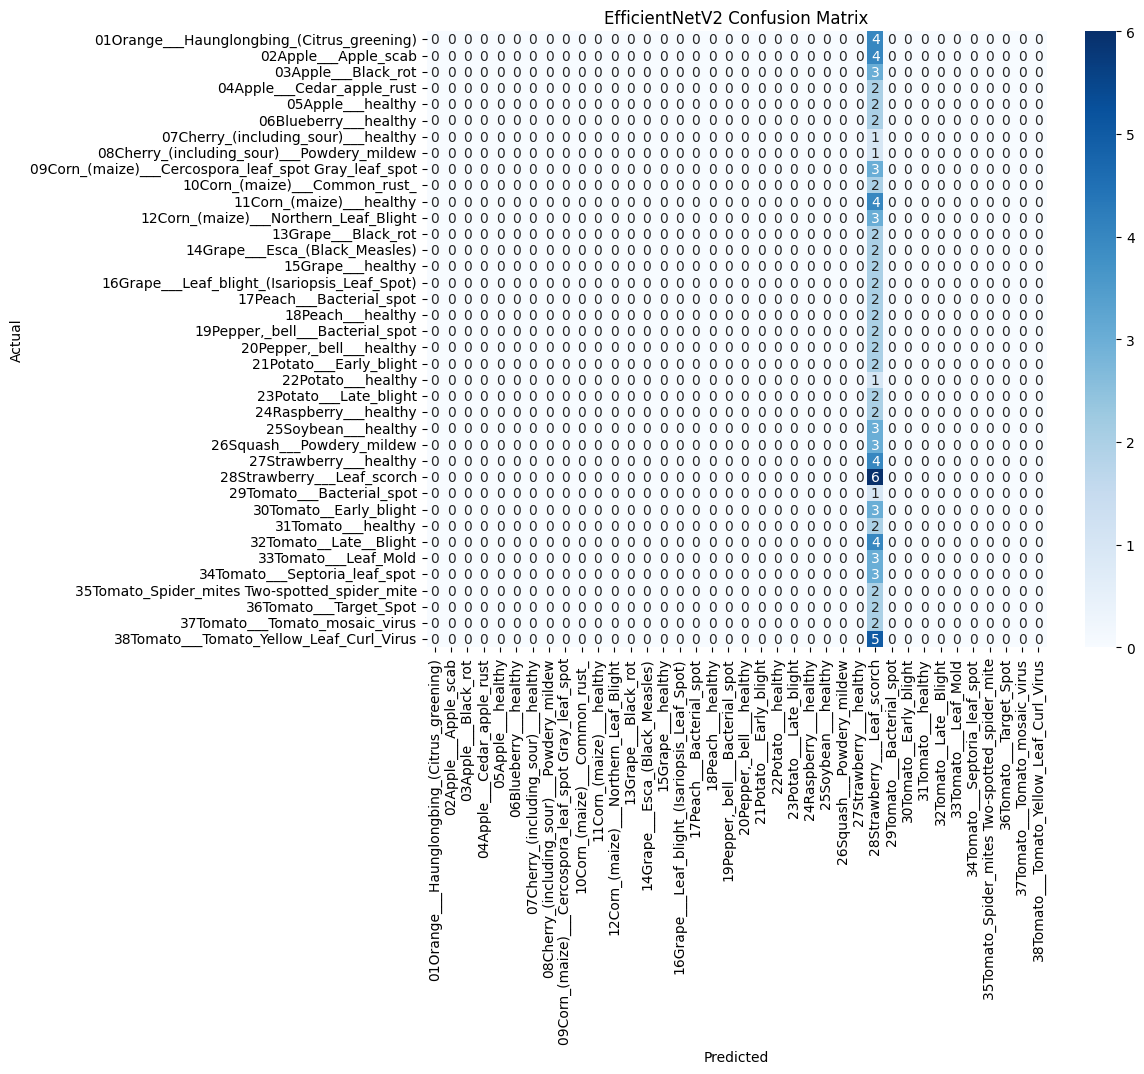

                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Train models
for name, base_model in models.items():
    print(f"Training {name}...")
    model = build_model(base_model, num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, callbacks=[early_stopping])
    
    model.save(f"{name}_PlantVillage.h5")
    model.save_weights(f"{name}.weights.h5")
    print(f"{name} model and weights saved.\n")
    
    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    
    # Plot accuracy (train, validation, test)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{name} Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{name} Loss')
    
    plt.savefig(f"{name}_training_plot.png")
    plt.show()
    
    # Confusion matrix
    print(f"Generating confusion matrix for {name}...\n")
    
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())  # Get class names

    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print("\n" + "="*50 + "\n")

print("Training, evaluation, and visualization completed.")

# Fine-tunning

In [8]:
def build_model(base_model, num_classes):
    for layer in base_model.layers[-30:]:  # Fine-tune 30 layer cuối
        layer.trainable = True  

    inputs = Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)  
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)  # Chuẩn hóa batch

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

# Define models
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "InceptionV0": InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "EfficientNetV2": EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
}

<ipython-input-8-a11590296cbf>:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),


Training ResNet50...
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0335 - loss: 4.4430 - val_accuracy: 0.0196 - val_loss: 3.8535
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step - accuracy: 0.1118 - loss: 3.6084 - val_accuracy: 0.0196 - val_loss: 3.6709
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.2747 - loss: 2.7885 - val_accuracy: 0.0196 - val_loss: 3.7605
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.4058 - loss: 2.2799 - val_accuracy: 0.0196 - val_loss: 4.3066
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 470ms/step - accuracy: 0.4609 - loss: 1.9318 - val_accuracy: 0.0196 - val_loss: 5.7348
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - accuracy: 0.5291 - loss: 1.7351 - val_accuracy: 0.0196 - val_loss: 6.3188
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.6748 - loss: 1.2619 - val_accuracy: 0.0196 - val_loss: 5.7478
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.6709 - loss:

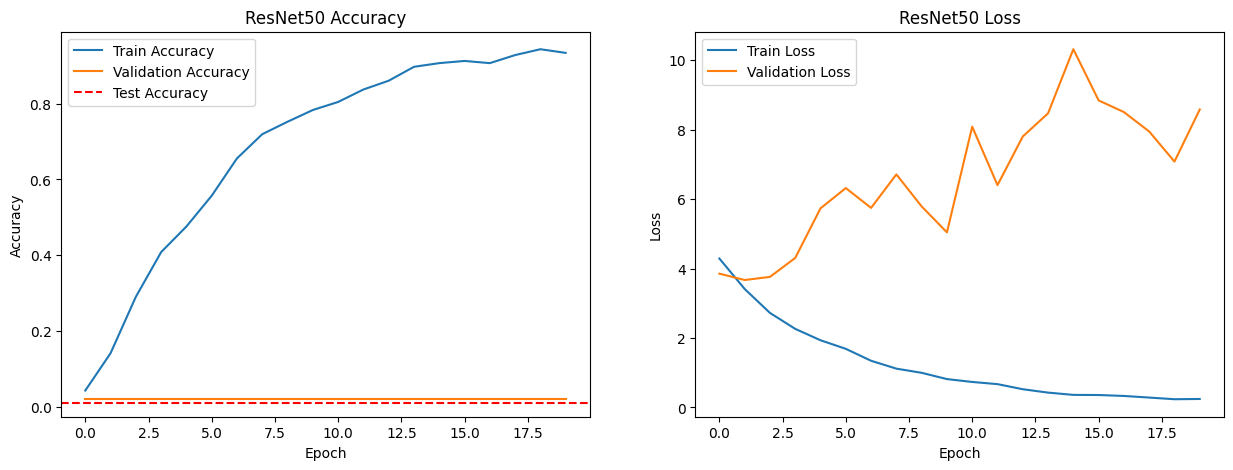

Generating confusion matrix for ResNet50...

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


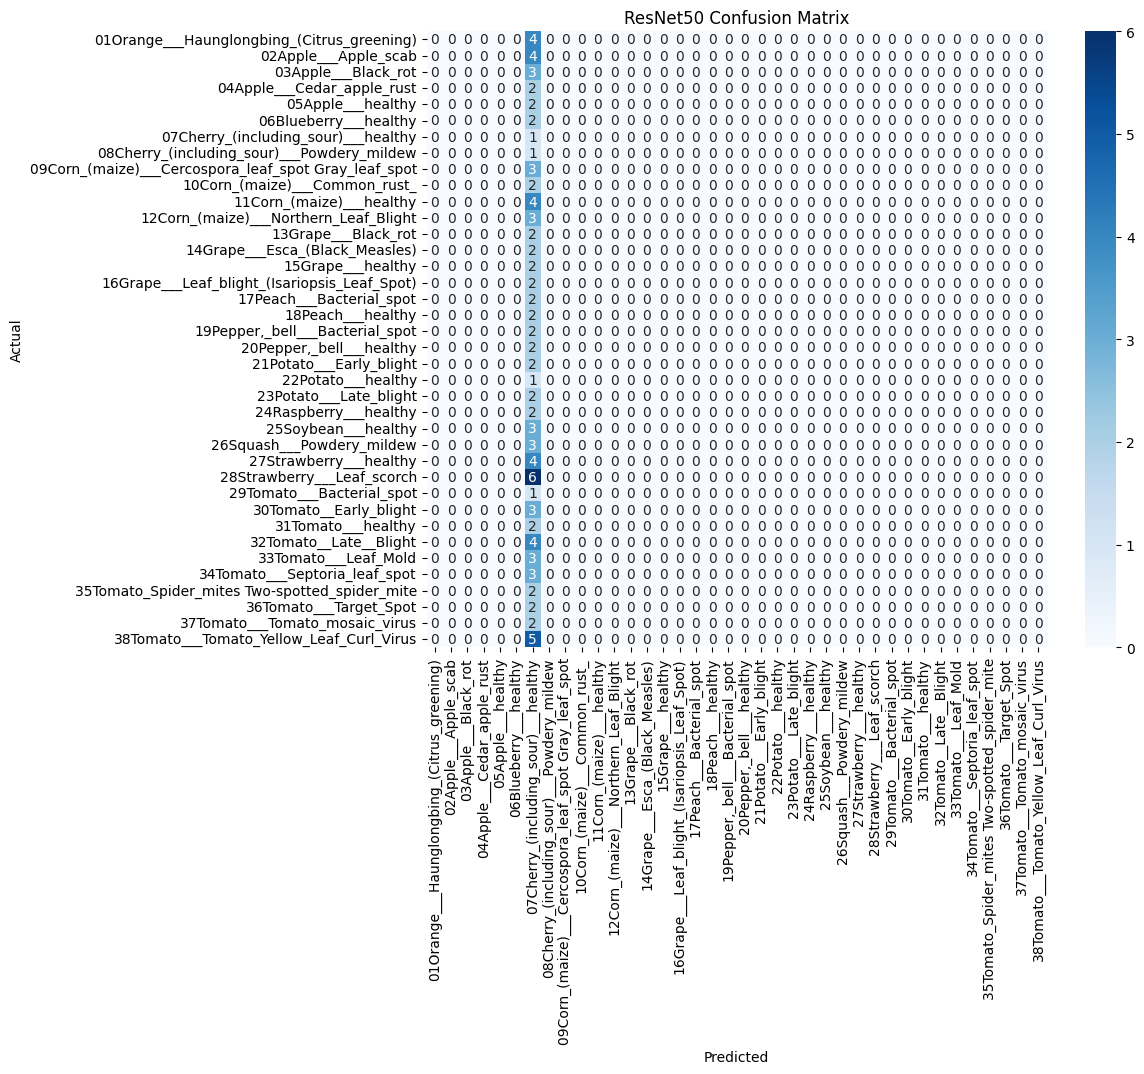

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.01      1.00      0.02         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

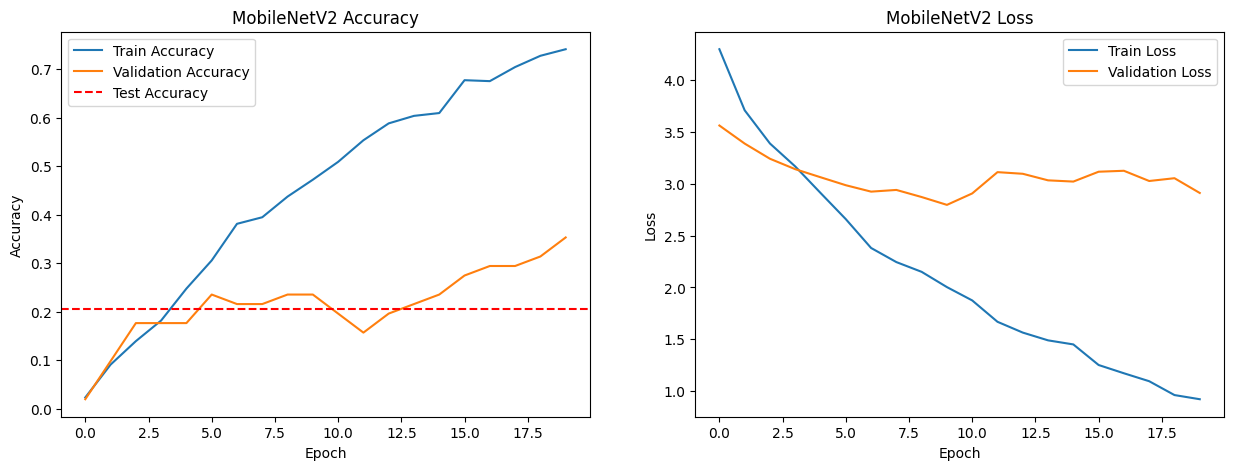

Generating confusion matrix for MobileNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 


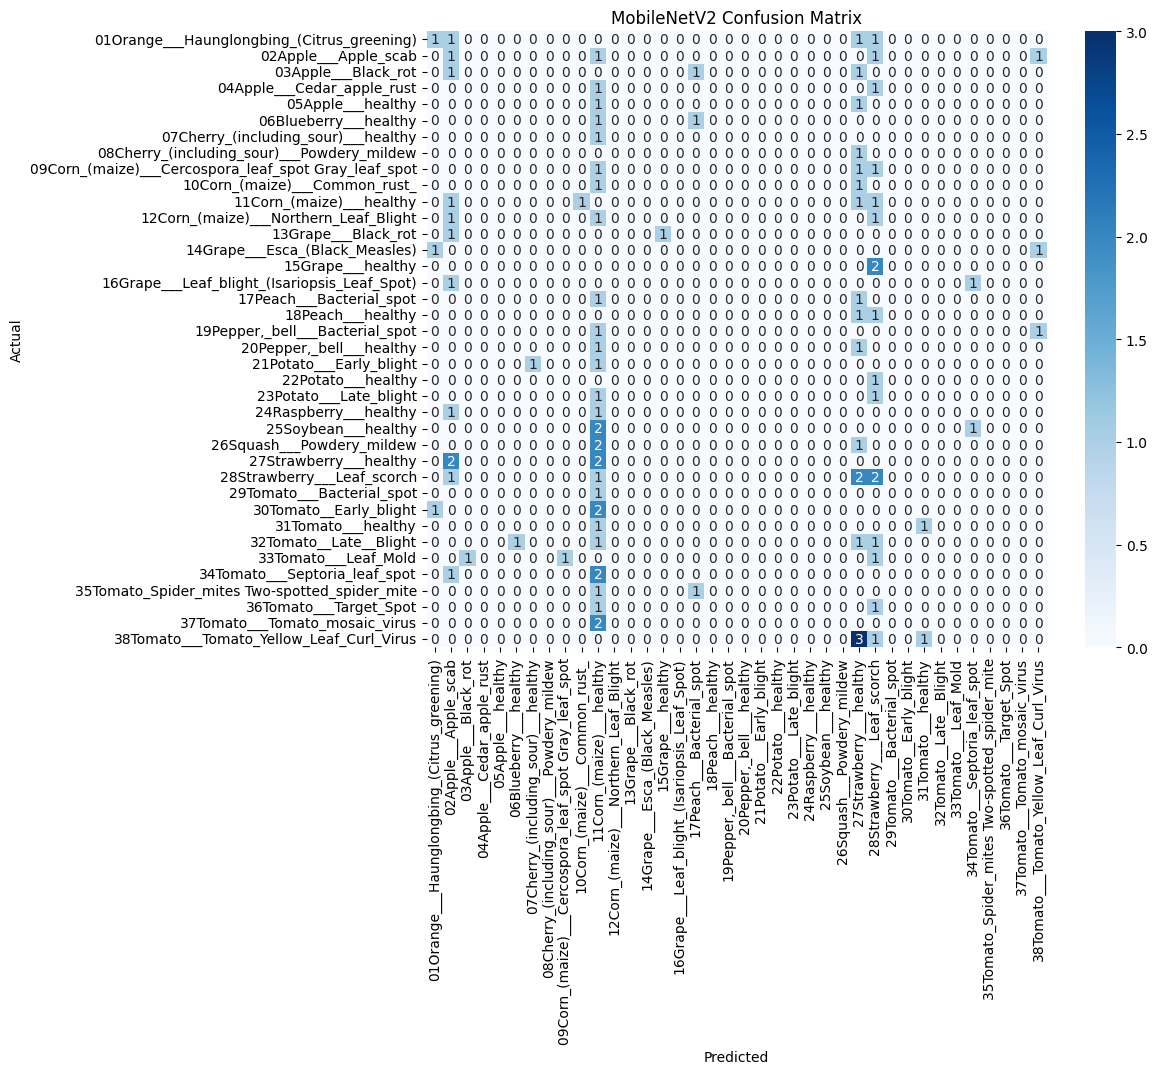

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.33      0.25      0.29         4
                                02Apple___Apple_scab       0.08      0.25      0.12         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

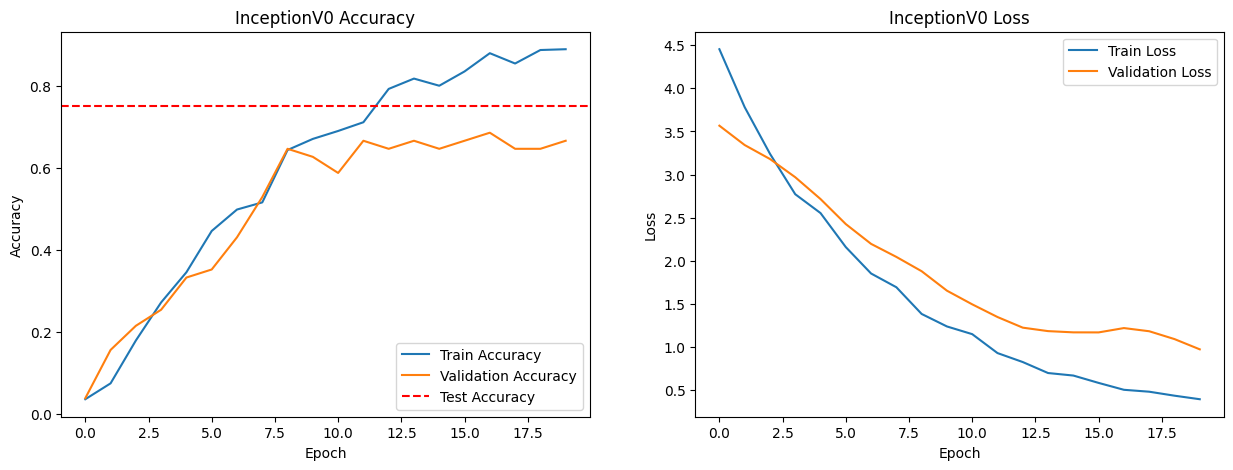

Generating confusion matrix for InceptionV0...

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


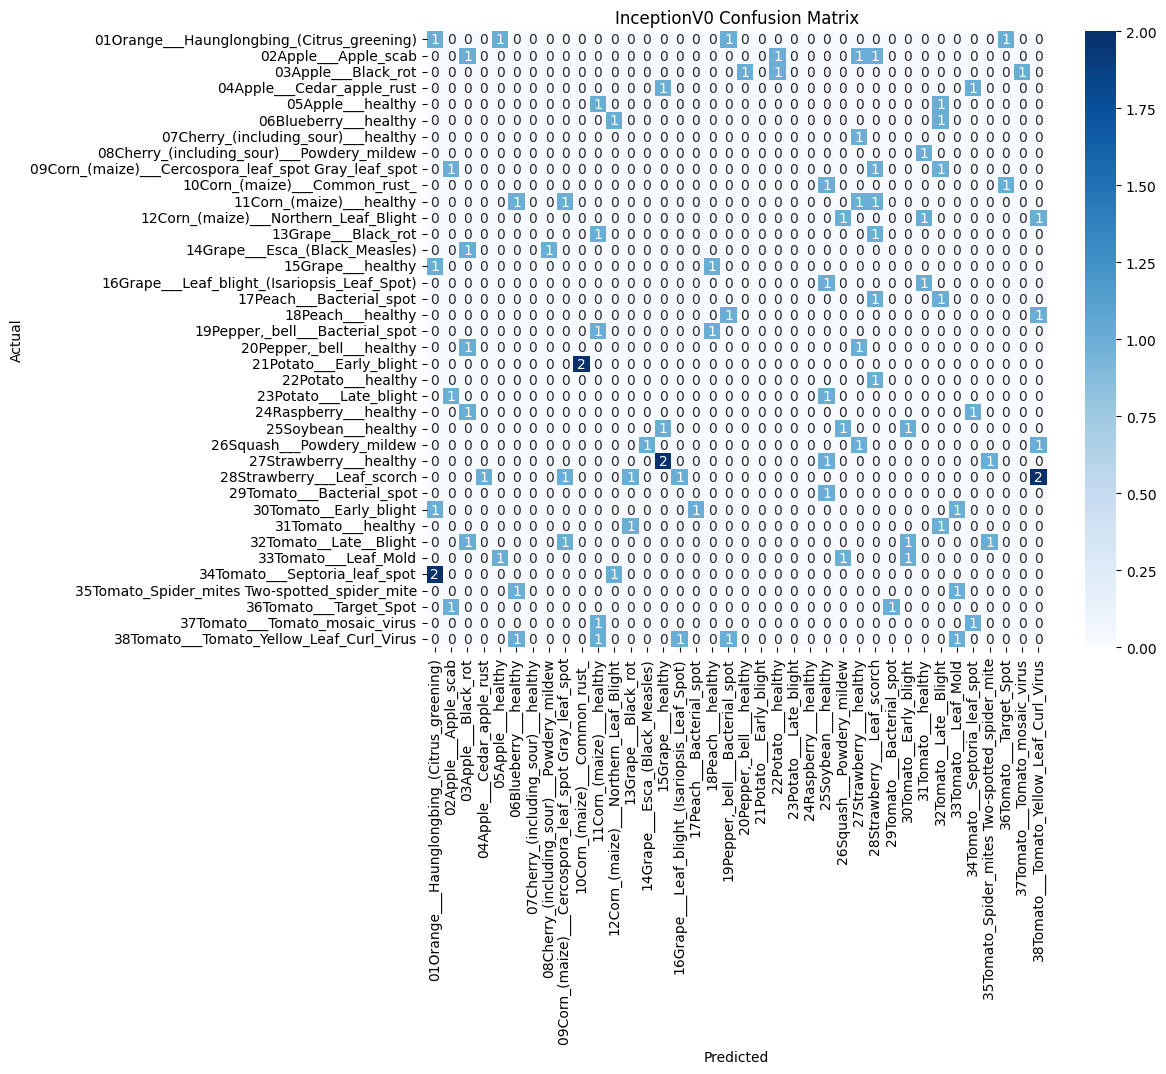

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.20      0.25      0.22         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

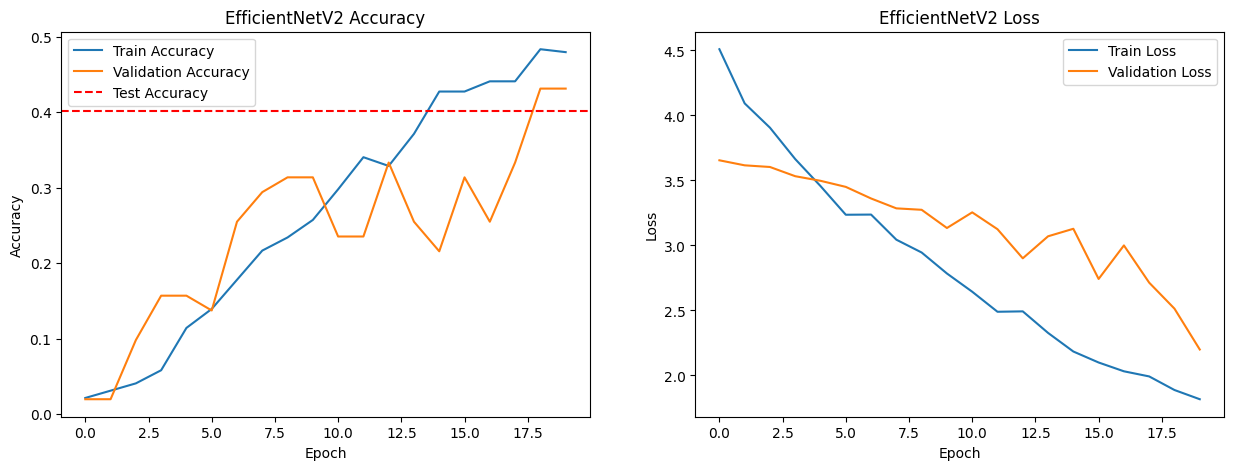

Generating confusion matrix for EfficientNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


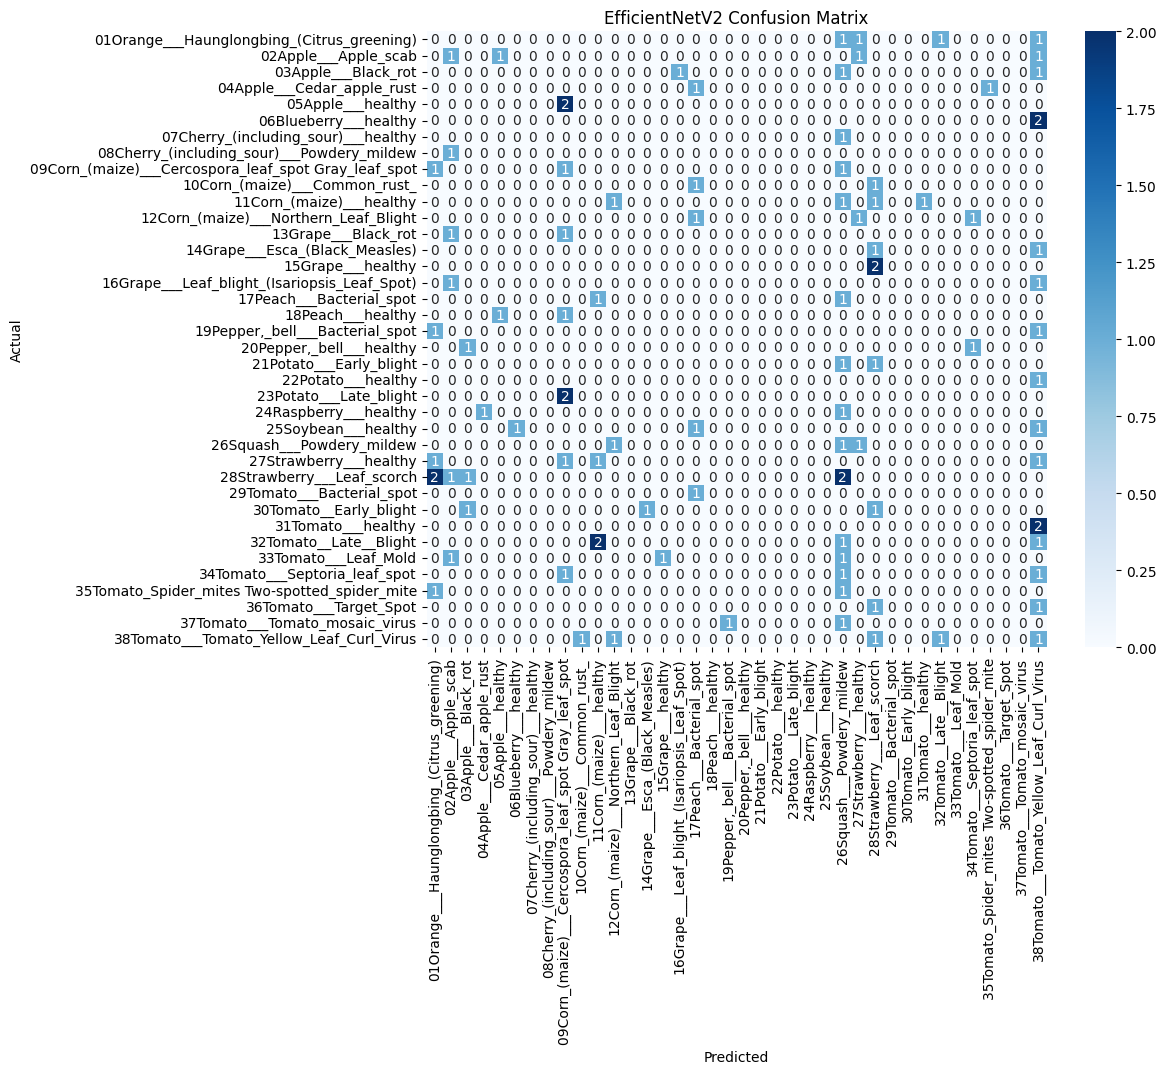

                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.17      0.25      0.20         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.11      0.33      0.17         3
                       10Corn_(maize)___Common_rust_       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Train models
for name, base_model in models.items():
    print(f"Training {name}...")
    model = build_model(base_model, num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, callbacks=[early_stopping])
    
    model.save(f"{name}_PlantVillage_ft.h5")
    model.save_weights(f"{name}_ft.weights.h5")
    print(f"{name} model and weights saved.\n")
    
    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    
    # Plot accuracy (train, validation, test)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{name} Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{name} Loss')
    
    plt.savefig(f"{name}_training_plot.png")
    plt.show()
    
    # Confusion matrix
    print(f"Generating confusion matrix for {name}...\n")
    
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())  # Get class names

    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print("\n" + "="*50 + "\n")

print("Training, evaluation, and visualization completed.")

# Fine-tunning + L2

In [10]:
from tensorflow.keras.regularizers import l2

def build_model(base_model, num_classes):
    for layer in base_model.layers[-30:]:  # Fine-tune 30 layer cuối
        layer.trainable = True  

    inputs = Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)  
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Thêm L2
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Thêm L2
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

# Define models
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "InceptionV0": InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "EfficientNetV2": EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
}

<ipython-input-10-0fb6e4ad4bc0>:25: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),


Training ResNet50...
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.0245 - loss: 16.1054 - val_accuracy: 0.0000e+00 - val_loss: 15.3590
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 0.1145 - loss: 14.9094 - val_accuracy: 0.0392 - val_loss: 15.6410
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.2702 - loss: 14.2543 - val_accuracy: 0.0392 - val_loss: 15.8009
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.4052 - loss: 13.5895 - val_accuracy: 0.0196 - val_loss: 15.3943
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - accuracy: 0.4864 - loss: 13.2785 - val_accuracy: 0.0392 - val_loss: 15.2149
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.5081 - loss: 13.0124 - val_accuracy: 0.0196 - val_loss: 15.8922
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.6495 - loss: 12.4771 - val_accuracy: 0.0392 - val_loss: 15.7439
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accura

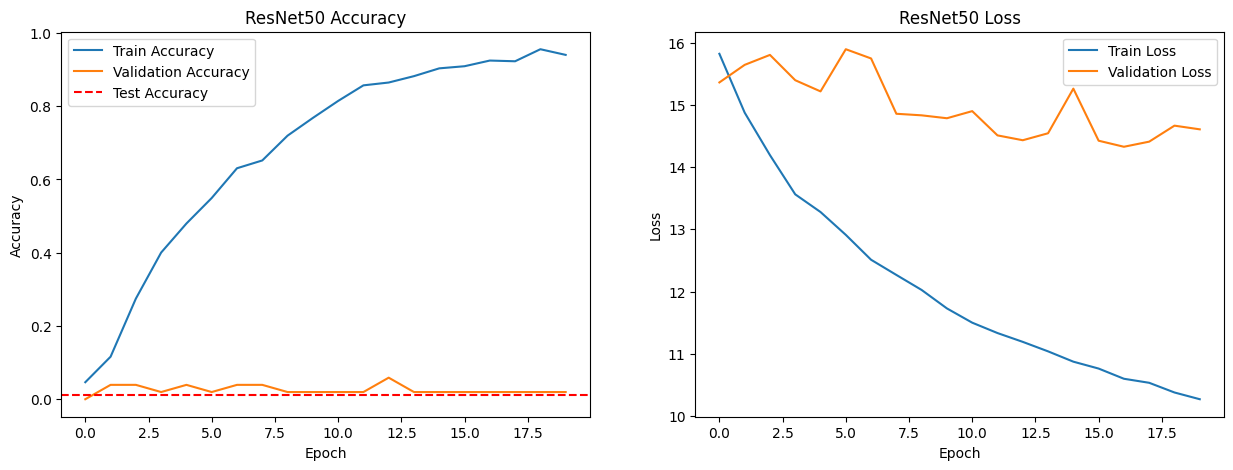

Generating confusion matrix for ResNet50...

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 995ms/step


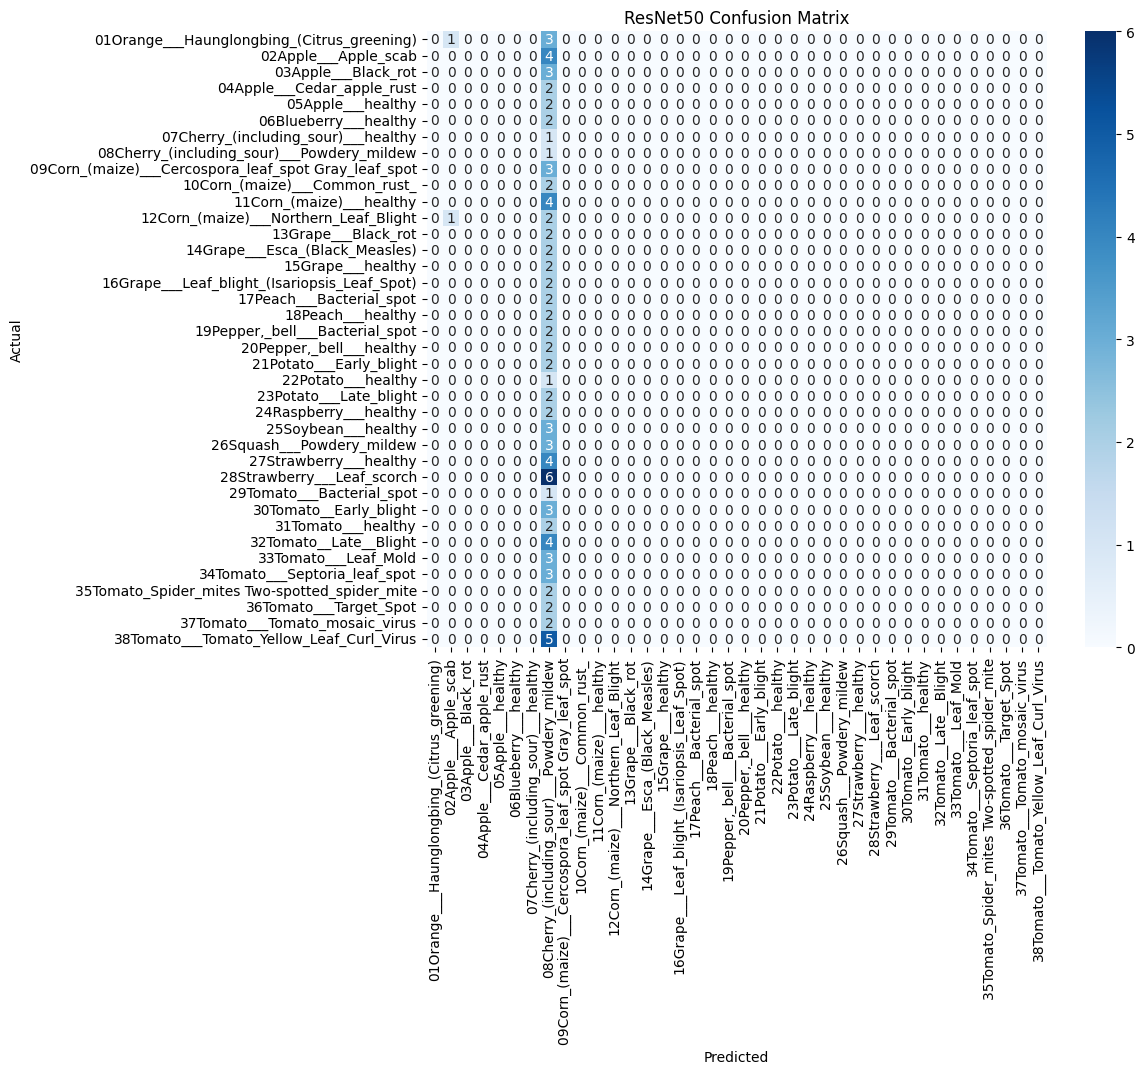

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.01      1.00      0.02         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

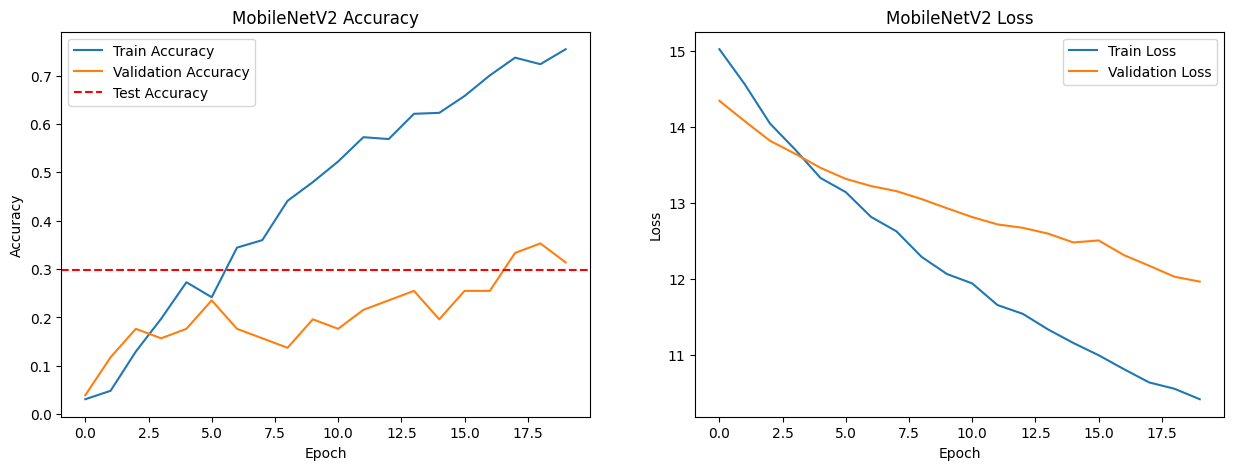

Generating confusion matrix for MobileNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step


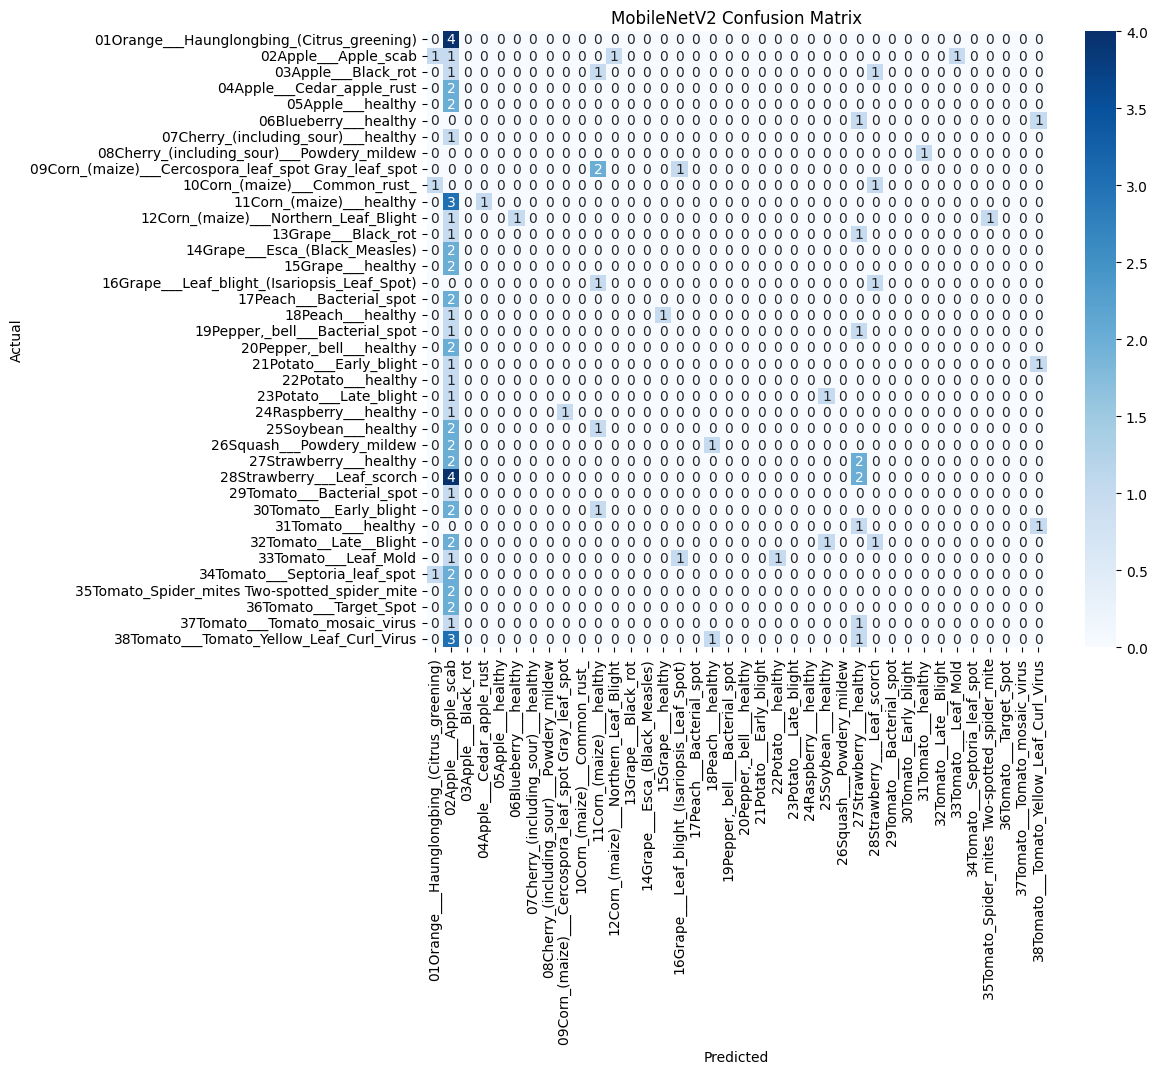

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.02      0.25      0.03         4
                                 03Apple___Black_rot       0.00      0.00      0.00         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

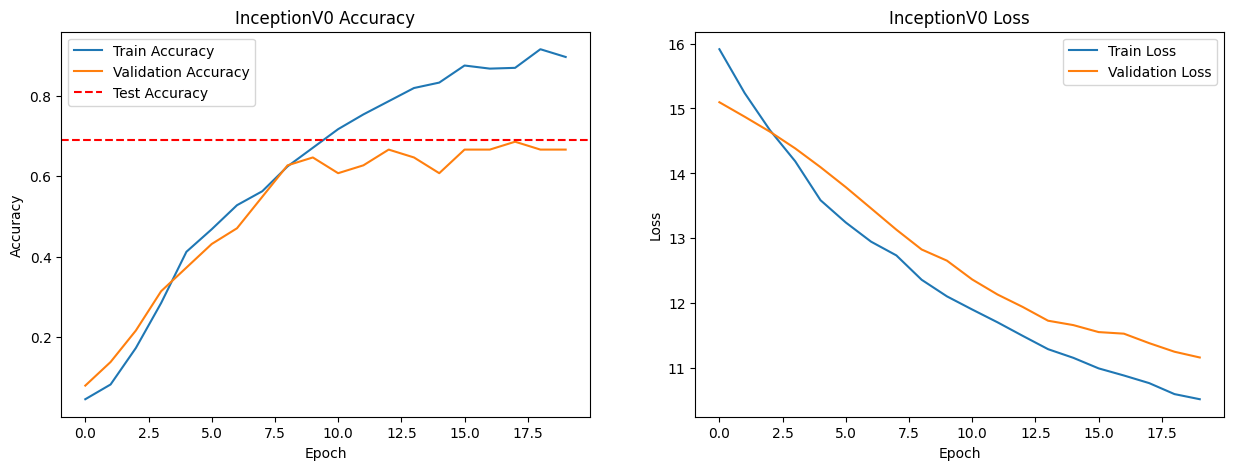

Generating confusion matrix for InceptionV0...

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


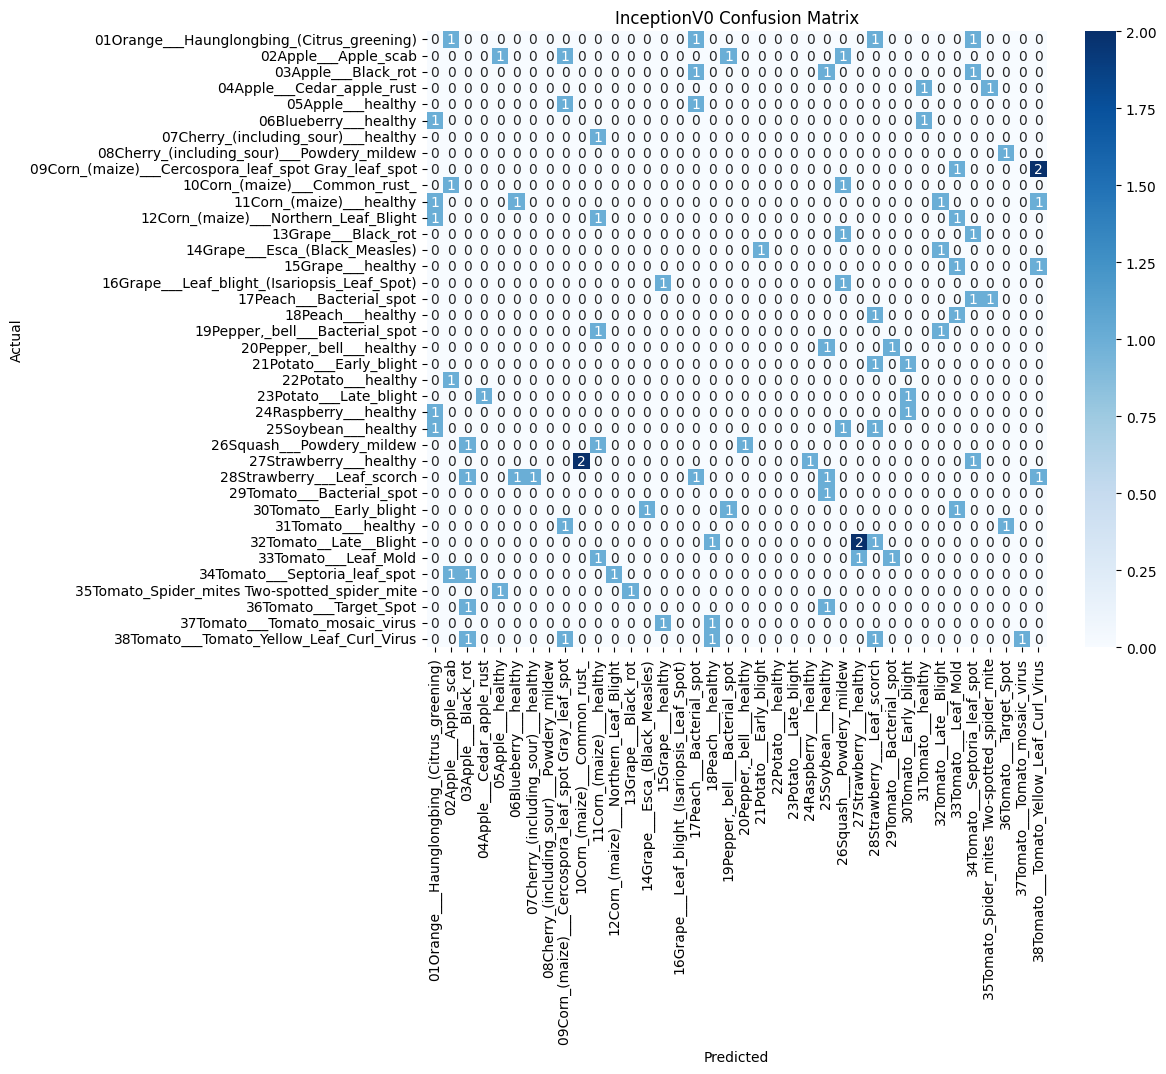

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00       4.0
                                02Apple___Apple_scab       0.00      0.00      0.00       4.0
                                 03Apple___Black_rot       0.00      0.00      0.00       3.0
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00       2.0
                                   05Apple___healthy       0.00      0.00      0.00       2.0
                               06Blueberry___healthy       0.00      0.00      0.00       2.0
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00       1.0
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       1.0
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       3.0
                       10Corn_(maize)___Common_rust_       

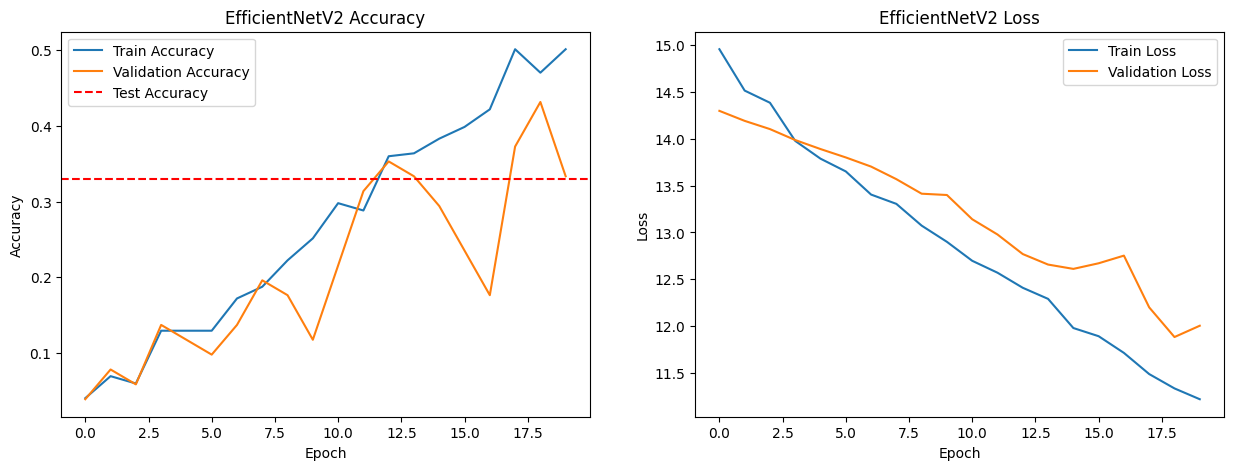

Generating confusion matrix for EfficientNetV2...

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


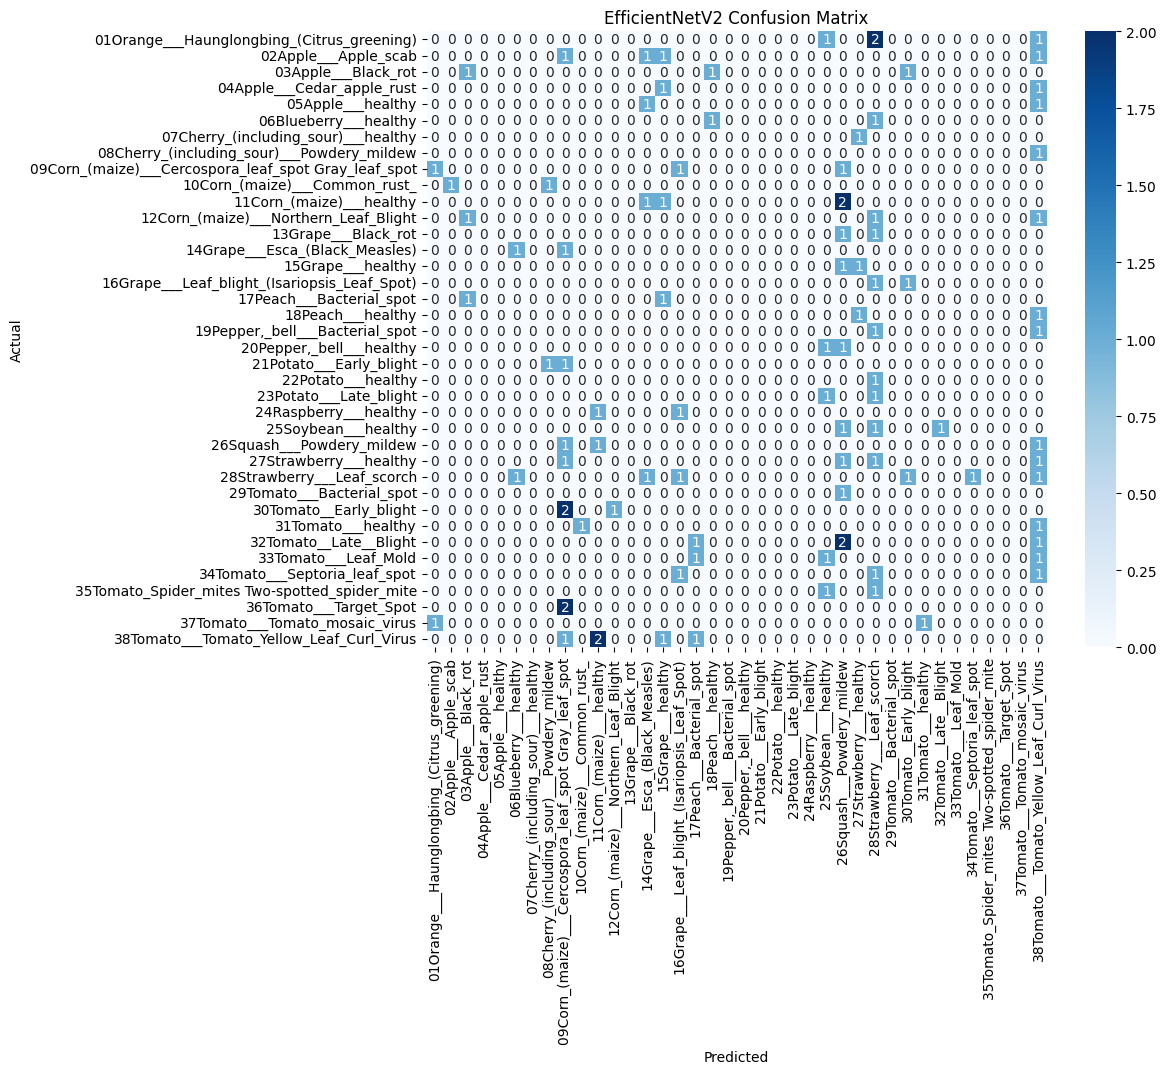

                                                      precision    recall  f1-score   support

          01Orange___Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         4
                                02Apple___Apple_scab       0.00      0.00      0.00         4
                                 03Apple___Black_rot       0.33      0.33      0.33         3
                          04Apple___Cedar_apple_rust       0.00      0.00      0.00         2
                                   05Apple___healthy       0.00      0.00      0.00         2
                               06Blueberry___healthy       0.00      0.00      0.00         2
                 07Cherry_(including_sour)___healthy       0.00      0.00      0.00         1
          08Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         1
09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         3
                       10Corn_(maize)___Common_rust_       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Train models
for name, base_model in models.items():
    print(f"Training {name}...")
    model = build_model(base_model, num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, callbacks=[early_stopping])
    
    model.save(f"{name}_PlantVillage_ft_l2.h5")
    model.save_weights(f"{name}_ft_l2.weights.h5")
    print(f"{name} model and weights saved.\n")
    
    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    
    # Plot accuracy (train, validation, test)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{name} Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{name} Loss')
    
    plt.savefig(f"{name}_training_plot.png")
    plt.show()
    
    # Confusion matrix
    print(f"Generating confusion matrix for {name}...\n")
    
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())  # Get class names

    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print("\n" + "="*50 + "\n")

print("Training, evaluation, and visualization completed.")

# Data Distribution

In [18]:
!ls /kaggle/working/FPDR/data/split_data

test  train  val


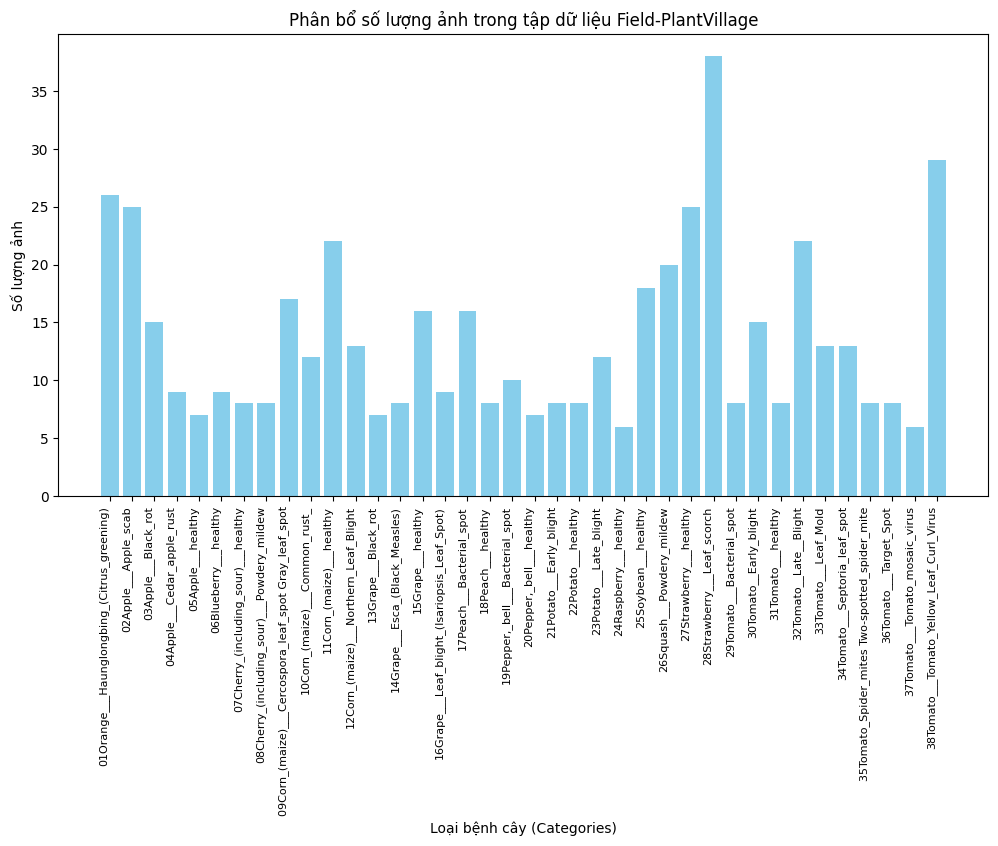

Biểu đồ đã được lưu tại: /kaggle/working/Field_PlantVillage_Distribution_train.png


In [21]:
import os
import matplotlib.pyplot as plt

# Đường dẫn thư mục gốc
base_path = "/kaggle/working/FPDR/data/split_data/train"

# Lấy danh sách các thư mục con (các lớp) theo thứ tự từ 1 đến 38
ordered_categories = [
    "01Orange___Haunglongbing_(Citrus_greening)",
    "02Apple___Apple_scab",
    "03Apple___Black_rot",
    "04Apple___Cedar_apple_rust",
    "05Apple___healthy",
    "06Blueberry___healthy",
    "07Cherry_(including_sour)___healthy",
    "08Cherry_(including_sour)___Powdery_mildew",
    "09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "10Corn_(maize)___Common_rust_",
    "11Corn_(maize)___healthy",
    "12Corn_(maize)___Northern_Leaf_Blight",
    "13Grape___Black_rot",
    "14Grape___Esca_(Black_Measles)",
    "15Grape___healthy",
    "16Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "17Peach___Bacterial_spot",
    "18Peach___healthy",
    "19Pepper,_bell___Bacterial_spot",
    "20Pepper,_bell___healthy",
    "21Potato___Early_blight",
    "22Potato___healthy",
    "23Potato___Late_blight",
    "24Raspberry___healthy",
    "25Soybean___healthy",
    "26Squash___Powdery_mildew",
    "27Strawberry___healthy",
    "28Strawberry___Leaf_scorch",
    "29Tomato___Bacterial_spot",
    "30Tomato__Early_blight",
    "31Tomato___healthy",
    "32Tomato__Late__Blight",
    "33Tomato___Leaf_Mold",
    "34Tomato___Septoria_leaf_spot",
    "35Tomato_Spider_mites Two-spotted_spider_mite",
    "36Tomato___Target_Spot",
    "37Tomato___Tomato_mosaic_virus",
    "38Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]

# Tạo danh sách số lượng ảnh tương ứng
image_counts = []
for category in ordered_categories:
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    else:
        num_images = 0  # Nếu không tìm thấy thư mục, gán 0 ảnh
    image_counts.append(num_images)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(ordered_categories, image_counts, color='skyblue')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel("Loại bệnh cây (Categories)")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bổ số lượng ảnh trong tập dữ liệu Field-PlantVillage")

# Lưu hình ảnh
save_path = "/kaggle/working/Field_PlantVillage_Distribution_train.png"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print(f"Biểu đồ đã được lưu tại: {save_path}")

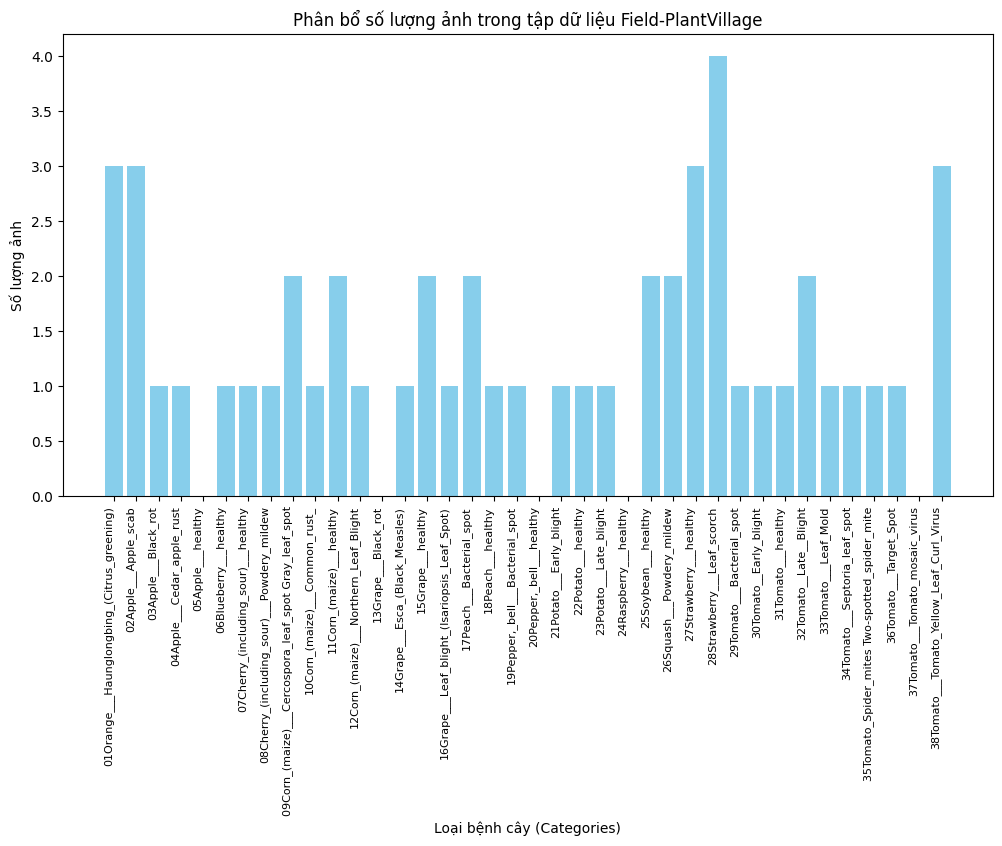

Biểu đồ đã được lưu tại: /kaggle/working/Field_PlantVillage_Distribution_val.png


In [22]:
import os
import matplotlib.pyplot as plt

# Đường dẫn thư mục gốc
base_path = "/kaggle/working/FPDR/data/split_data/val"

# Lấy danh sách các thư mục con (các lớp) theo thứ tự từ 1 đến 38
ordered_categories = [
    "01Orange___Haunglongbing_(Citrus_greening)",
    "02Apple___Apple_scab",
    "03Apple___Black_rot",
    "04Apple___Cedar_apple_rust",
    "05Apple___healthy",
    "06Blueberry___healthy",
    "07Cherry_(including_sour)___healthy",
    "08Cherry_(including_sour)___Powdery_mildew",
    "09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "10Corn_(maize)___Common_rust_",
    "11Corn_(maize)___healthy",
    "12Corn_(maize)___Northern_Leaf_Blight",
    "13Grape___Black_rot",
    "14Grape___Esca_(Black_Measles)",
    "15Grape___healthy",
    "16Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "17Peach___Bacterial_spot",
    "18Peach___healthy",
    "19Pepper,_bell___Bacterial_spot",
    "20Pepper,_bell___healthy",
    "21Potato___Early_blight",
    "22Potato___healthy",
    "23Potato___Late_blight",
    "24Raspberry___healthy",
    "25Soybean___healthy",
    "26Squash___Powdery_mildew",
    "27Strawberry___healthy",
    "28Strawberry___Leaf_scorch",
    "29Tomato___Bacterial_spot",
    "30Tomato__Early_blight",
    "31Tomato___healthy",
    "32Tomato__Late__Blight",
    "33Tomato___Leaf_Mold",
    "34Tomato___Septoria_leaf_spot",
    "35Tomato_Spider_mites Two-spotted_spider_mite",
    "36Tomato___Target_Spot",
    "37Tomato___Tomato_mosaic_virus",
    "38Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]

# Tạo danh sách số lượng ảnh tương ứng
image_counts = []
for category in ordered_categories:
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    else:
        num_images = 0  # Nếu không tìm thấy thư mục, gán 0 ảnh
    image_counts.append(num_images)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(ordered_categories, image_counts, color='skyblue')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel("Loại bệnh cây (Categories)")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bổ số lượng ảnh trong tập dữ liệu Field-PlantVillage")

# Lưu hình ảnh
save_path = "/kaggle/working/Field_PlantVillage_Distribution_val.png"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print(f"Biểu đồ đã được lưu tại: {save_path}")

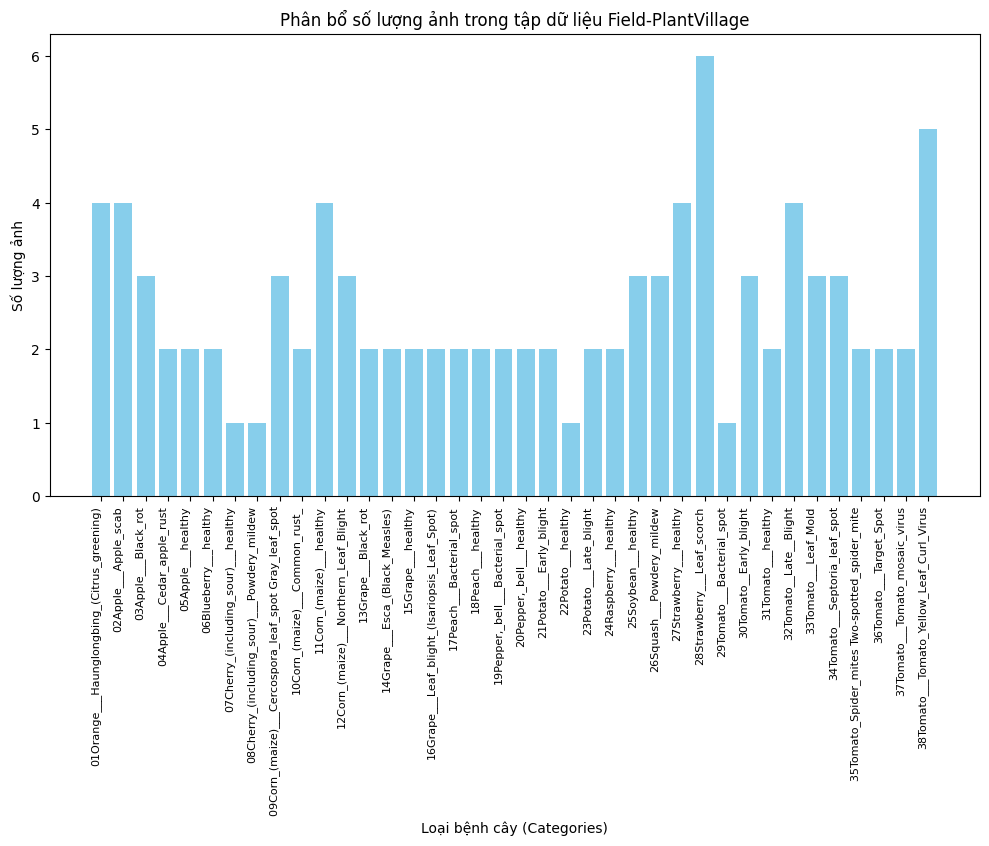

Biểu đồ đã được lưu tại: /kaggle/working/Field_PlantVillage_Distribution_test.png


In [23]:
import os
import matplotlib.pyplot as plt

# Đường dẫn thư mục gốc
base_path = "/kaggle/working/FPDR/data/split_data/test"

# Lấy danh sách các thư mục con (các lớp) theo thứ tự từ 1 đến 38
ordered_categories = [
    "01Orange___Haunglongbing_(Citrus_greening)",
    "02Apple___Apple_scab",
    "03Apple___Black_rot",
    "04Apple___Cedar_apple_rust",
    "05Apple___healthy",
    "06Blueberry___healthy",
    "07Cherry_(including_sour)___healthy",
    "08Cherry_(including_sour)___Powdery_mildew",
    "09Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "10Corn_(maize)___Common_rust_",
    "11Corn_(maize)___healthy",
    "12Corn_(maize)___Northern_Leaf_Blight",
    "13Grape___Black_rot",
    "14Grape___Esca_(Black_Measles)",
    "15Grape___healthy",
    "16Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "17Peach___Bacterial_spot",
    "18Peach___healthy",
    "19Pepper,_bell___Bacterial_spot",
    "20Pepper,_bell___healthy",
    "21Potato___Early_blight",
    "22Potato___healthy",
    "23Potato___Late_blight",
    "24Raspberry___healthy",
    "25Soybean___healthy",
    "26Squash___Powdery_mildew",
    "27Strawberry___healthy",
    "28Strawberry___Leaf_scorch",
    "29Tomato___Bacterial_spot",
    "30Tomato__Early_blight",
    "31Tomato___healthy",
    "32Tomato__Late__Blight",
    "33Tomato___Leaf_Mold",
    "34Tomato___Septoria_leaf_spot",
    "35Tomato_Spider_mites Two-spotted_spider_mite",
    "36Tomato___Target_Spot",
    "37Tomato___Tomato_mosaic_virus",
    "38Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]

# Tạo danh sách số lượng ảnh tương ứng
image_counts = []
for category in ordered_categories:
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    else:
        num_images = 0  # Nếu không tìm thấy thư mục, gán 0 ảnh
    image_counts.append(num_images)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(ordered_categories, image_counts, color='skyblue')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel("Loại bệnh cây (Categories)")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bổ số lượng ảnh trong tập dữ liệu Field-PlantVillage")

# Lưu hình ảnh
save_path = "/kaggle/working/Field_PlantVillage_Distribution_test.png"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print(f"Biểu đồ đã được lưu tại: {save_path}")